# Team 8 SC1015 project

---

This notebook covers our project. Our project's problem definition focuses on utilising machine learning methods to forecast the causal factors contributing to the rise in diabetes prevalence. By doing so, we aim to empower health professionals, government entities, and individuals with the knowledge needed to proactively prevent diabetes onset. This approach can significantly improve health outcomes and overall quality of life.

In [16]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import math
sb.set() # set the default Seaborn style for graphics
from scipy.stats import pointbiserialr, chi2_contingency
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, make_scorer, classification_report, confusion_matrix
from sklearn.datasets import load_iris  
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [17]:
#import dataset
csvdata = pd.read_csv('csvdata.csv')

# Data cleaning

In [18]:
#create a copy of the dataset
csvdata_clean = csvdata.copy()

#define wanted and relevant variables
important_cols = ['SMOKDAY2','_AGEG5YR','SEXVAR','EXERANY2','ALCDAY5','_BMI5CAT','INCOME2','MARITAL','SLEPTIM1','EDUCA','MEDCOST', 'POORHLTH','CHECKUP1','CVDCRHD4','CVDINFR4','DIABETE4']

#combine all wanted variables into a dataframe
newdata = csvdata[important_cols].copy()

#drop all null values
newdata.dropna(inplace=True)
newdata

,SMOKDAY2,_AGEG5YR,SEXVAR,EXERANY2,ALCDAY5,_BMI5CAT,INCOME2,MARITAL,SLEPTIM1,EDUCA,MEDCOST,POORHLTH,CHECKUP1,CVDCRHD4,CVDINFR4,DIABETE4
0,1.0,8.0,2.0,1.0,888.0,1.0,1.0,2.0,5.0,6.0,1.0,3.0,4.0,2.0,2.0,1.0
5,3.0,10.0,1.0,1.0,888.0,3.0,5.0,4.0,8.0,4.0,2.0,88.0,2.0,2.0,2.0,1.0
9,3.0,12.0,2.0,2.0,888.0,3.0,99.0,3.0,12.0,2.0,2.0,88.0,1.0,1.0,2.0,3.0
11,3.0,13.0,2.0,2.0,888.0,4.0,4.0,3.0,9.0,5.0,2.0,88.0,1.0,2.0,2.0,1.0
15,1.0,9.0,1.0,2.0,888.0,4.0,77.0,2.0,15.0,4.0,2.0,30.0,1.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401916,3.0,8.0,2.0,2.0,202.0,3.0,4.0,5.0,7.0,6.0,2.0,88.0,1.0,1.0,2.0,1.0
401921,1.0,9.0,1.0,2.0,888.0,4.0,77.0,2.0,5.0,2.0,1.0,88.0,2.0,2.0,2.0,1.0
401938,3.0,11.0,2.0,1.0,888.0,2.0,1.0,2.0,5.0,4.0,2.0,88.0,2.0,2.0,2.0,3.0
401941,1.0,8.0,2.0,2.0,888.0,4.0,99.0,5.0,4.0,4.0,2.0,30.0,1.0,2.0,2.0,3.0


In [19]:
#Further cleaning; removing irrelevant values

#Smoke process
newdata['SMOKDAY2'].replace([7,9], pd.NA, inplace=True)
newdata.dropna(subset=['SMOKDAY2'], inplace=True)
newdata['SMOKDAY2'].value_counts()

newdata['SMOKEEVERYDAY'] = (newdata['SMOKDAY2'] == 1).astype(int)
newdata['SMOKESOMEDAYS'] = (newdata['SMOKDAY2'] == 2).astype(int)
newdata['DONOTSMOKE'] = (newdata['SMOKDAY2'] == 3).astype(int)

#Age process
newdata['_AGEG5YR'].replace([14], pd.NA, inplace=True)
newdata.dropna(subset=['_AGEG5YR'], inplace=True)

#Sex process 
newdata['MALE'] = (newdata['SEXVAR'] == 1).astype(int)
newdata['FEMALE'] = (newdata['SEXVAR'] == 2).astype(int)

#Exercise process
newdata['EXERANY2'].replace([7, 9], pd.NA, inplace=True)
newdata.dropna(subset=['EXERANY2'], inplace=True)
newdata['EXERANY2'] = newdata['EXERANY2'].replace({1: 1, 2: 0})

#Alcohol process
newdata['ALCDAY5'].replace([777, 999], pd.NA, inplace=True)
newdata.dropna(subset=['ALCDAY5'], inplace=True)
newdata['ALCDAY5'] = newdata['ALCDAY5'].replace({888: 0})
newdata = newdata[~newdata['ALCDAY5'].between(101, 107)]
newdata.loc[newdata['ALCDAY5'].between(201, 230), 'ALCDAY5'] -= 200 #Subtract 200 from all values between 201 and 230

#Income process
newdata = newdata[(newdata['INCOME2']!=77) & (newdata['INCOME2']!=99)]

#Marital process
newdata = newdata[(newdata['MARITAL']!=4) & (newdata['MARITAL']!=6) & (newdata['MARITAL']!=9)]
newdata['MARRIED'] = (newdata['MARITAL'] == 1).astype(int)
newdata['DIVORCED'] = (newdata['MARITAL'] == 2).astype(int)
newdata['WIDOWED'] = (newdata['MARITAL'] == 3).astype(int)
newdata['NEVER_MARRIED'] = (newdata['MARITAL'] == 5).astype(int)

#Sleeptime process
newdata = newdata[(newdata['SLEPTIM1']!=77) & (newdata['SLEPTIM1']!=99)]

#Education process
newdata = newdata[(newdata['EDUCA']!=9)]

#Poorhealth process
newdata = newdata[(newdata['POORHLTH'] != 77) & (newdata['POORHLTH'] != 99)]
newdata['POORHLTH'].replace({88.0: 0}, inplace=True)
newdata['POORHLTH'] = newdata['POORHLTH'].astype(int)

#Costbarrier process
newdata = newdata[(newdata['MEDCOST'] != 7) & (newdata['MEDCOST'] != 9)]
newdata['MEDCOST'].replace({2.0: 0}, inplace=True)
newdata['MEDCOST'] = newdata['MEDCOST'].astype(int)

#Checkup process
newdata = newdata[(newdata['CHECKUP1'] != 7) & (newdata['CHECKUP1'] != 9)]
newdata['CHECKUP1'].replace({8.0: 5}, inplace=True)
newdata['CHECKUP1'] = newdata['CHECKUP1'].astype(int)

#Heart disease process 
newdata = newdata[(newdata['CVDCRHD4'] != 7) & (newdata['CVDCRHD4'] != 9)]
newdata['CVDCRHD4'].replace({2.0: 0}, inplace=True)

#Heart attack process
newdata = newdata[(newdata['CVDINFR4'] != 7) & (newdata['CVDINFR4'] != 9)]
newdata['CVDINFR4'].replace({2.0: 0}, inplace=True)

#Diabetes process
newdata = newdata[(newdata['DIABETE4'] != 2) & (newdata['DIABETE4'] != 4) & (newdata['DIABETE4'] != 7) & (newdata['DIABETE4'] != 9)]
newdata['DIABETE4'].replace({3.0: 0, 1.0: 1}, inplace=True)
newdata['DIABETE4'] = newdata['DIABETE4'].astype(int)

In [20]:
#drop original columns as part of one-hot encoding process
columns_to_drop = ['SMOKDAY2','SEXVAR','MARITAL']
newdata.drop(columns=columns_to_drop, inplace=True)

In [21]:
#rename columns for clarity
new_column_names = {
    '_AGEG5YR': 'AGE_RANGE',
    'EXERANY2': 'EXERCISE',
    'ALCDAY5': 'ALC_MONTH',
    '_BMI5CAT': 'BMI_CAT',
    'INCOME2': 'ANNUAL_INCOME',
    'SLEPTIM1': 'AV_SLEEP',
    'EDUCA': 'HIGHEST_EDU',
    'MEDCOST' : 'COST_BARRIER',
    'POORHLTH': 'POOR_HEALTH',
    'DIABETE4': 'DIABETES',
    'SMOKEEVERYDAY' : 'SMOKE_EVERYDAY',
    'SMOKESOMEDAYS' :'SMOKE_SOMEDAYS',
    'DONOTSMOKE': 'DO_NOT_SMOKE',
    'CVDCRHD4' : 'HEART_DISEASE',
    'CVDINFR4' : 'HEART_ATTACK',
    'CHECKUP1' : 'LAST_CHECKUP'
}
newdata = newdata.rename(columns=new_column_names)
newdata

,AGE_RANGE,EXERCISE,ALC_MONTH,BMI_CAT,ANNUAL_INCOME,AV_SLEEP,HIGHEST_EDU,COST_BARRIER,POOR_HEALTH,LAST_CHECKUP,...,DIABETES,SMOKE_EVERYDAY,SMOKE_SOMEDAYS,DO_NOT_SMOKE,MALE,FEMALE,MARRIED,DIVORCED,WIDOWED,NEVER_MARRIED
0,8.0,1.0,0.0,1.0,1.0,5.0,6.0,1,3,4,...,1,1,0,0,0,1,0,1,0,0
11,13.0,0.0,0.0,4.0,4.0,9.0,5.0,0,0,1,...,1,0,0,1,0,1,0,0,1,0
19,9.0,0.0,0.0,3.0,7.0,5.0,4.0,0,10,1,...,0,1,0,0,0,1,1,0,0,0
29,6.0,1.0,0.0,3.0,7.0,6.0,4.0,0,0,1,...,0,0,0,1,0,1,1,0,0,0
32,9.0,0.0,0.0,3.0,8.0,6.0,5.0,0,30,1,...,0,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401865,12.0,0.0,0.0,1.0,3.0,5.0,4.0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
401867,7.0,0.0,0.0,4.0,1.0,5.0,4.0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
401912,9.0,1.0,0.0,2.0,2.0,8.0,5.0,0,3,1,...,0,0,1,0,0,1,0,0,0,1
401916,8.0,0.0,2.0,3.0,4.0,7.0,6.0,0,0,1,...,1,0,0,1,0,1,0,0,0,1


In [22]:
#print info
newdata.info()


<class 'pandas.core.frame.DataFrame'>
Index: 47672 entries, 0 to 401938
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AGE_RANGE       47672 non-null  object 
 1   EXERCISE        47672 non-null  float64
 2   ALC_MONTH       47672 non-null  float64
 3   BMI_CAT         47672 non-null  float64
 4   ANNUAL_INCOME   47672 non-null  float64
 5   AV_SLEEP        47672 non-null  float64
 6   HIGHEST_EDU     47672 non-null  float64
 7   COST_BARRIER    47672 non-null  int32  
 8   POOR_HEALTH     47672 non-null  int32  
 9   LAST_CHECKUP    47672 non-null  int32  
 10  HEART_DISEASE   47672 non-null  float64
 11  HEART_ATTACK    47672 non-null  float64
 12  DIABETES        47672 non-null  int32  
 13  SMOKE_EVERYDAY  47672 non-null  int32  
 14  SMOKE_SOMEDAYS  47672 non-null  int32  
 15  DO_NOT_SMOKE    47672 non-null  int32  
 16  MALE            47672 non-null  int32  
 17  FEMALE          47672 non-null  int

In [23]:
#Convert categorical variables to dtype category
columns_to_convert_to_cat = ['AGE_RANGE', 'EXERCISE','BMI_CAT', 'ANNUAL_INCOME','HIGHEST_EDU', 'COST_BARRIER','LAST_CHECKUP', 'HEART_DISEASE','HEART_ATTACK','DIABETES']
newdata[columns_to_convert_to_cat] = newdata[columns_to_convert_to_cat].astype('category')

#Convert numerical variables to dtype float
newdata['POOR_HEALTH'] = newdata['POOR_HEALTH'].astype('float')

#Leave one-hot encoded variables as dtype int

newdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47672 entries, 0 to 401938
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   AGE_RANGE       47672 non-null  category
 1   EXERCISE        47672 non-null  category
 2   ALC_MONTH       47672 non-null  float64 
 3   BMI_CAT         47672 non-null  category
 4   ANNUAL_INCOME   47672 non-null  category
 5   AV_SLEEP        47672 non-null  float64 
 6   HIGHEST_EDU     47672 non-null  category
 7   COST_BARRIER    47672 non-null  category
 8   POOR_HEALTH     47672 non-null  float64 
 9   LAST_CHECKUP    47672 non-null  category
 10  HEART_DISEASE   47672 non-null  category
 11  HEART_ATTACK    47672 non-null  category
 12  DIABETES        47672 non-null  category
 13  SMOKE_EVERYDAY  47672 non-null  int32   
 14  SMOKE_SOMEDAYS  47672 non-null  int32   
 15  DO_NOT_SMOKE    47672 non-null  int32   
 16  MALE            47672 non-null  int32   
 17  FEMALE          

# Exploratory data analysis (EDA)

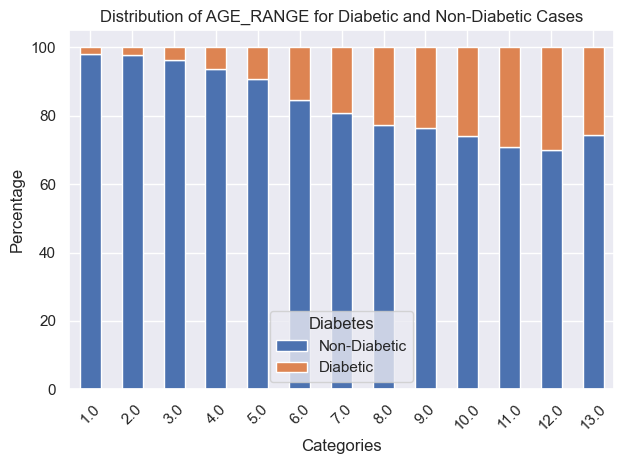

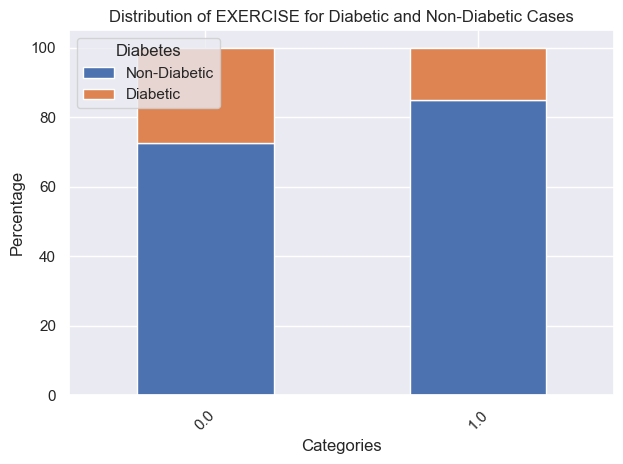

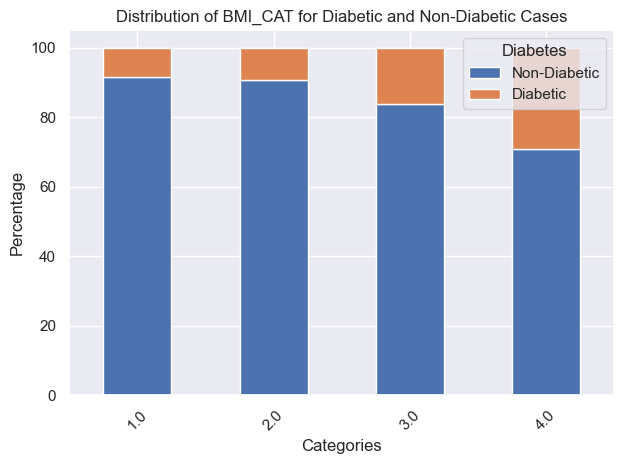

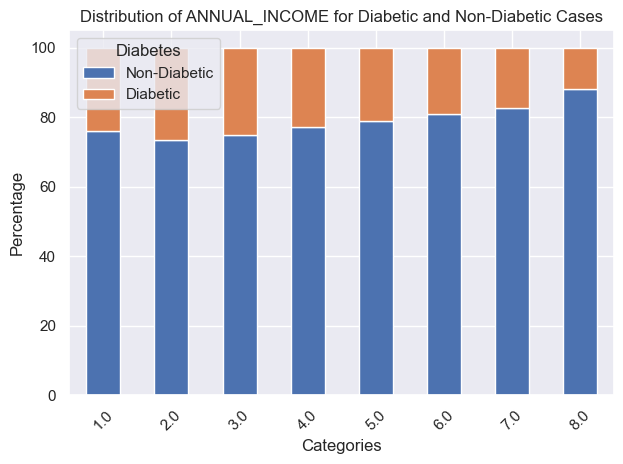

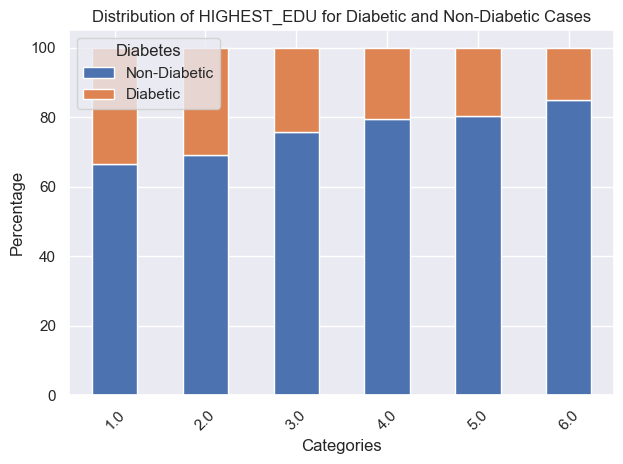

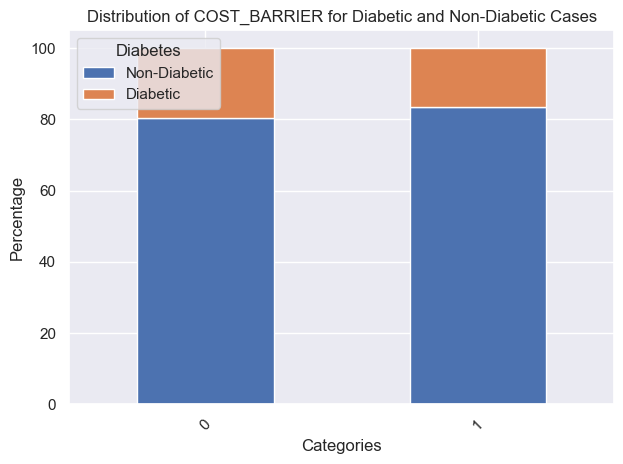

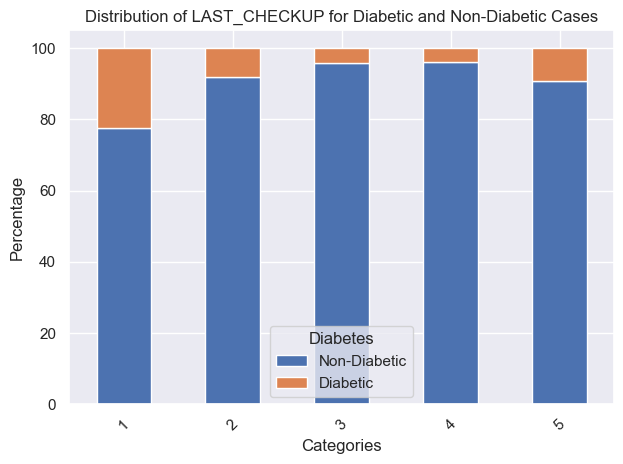

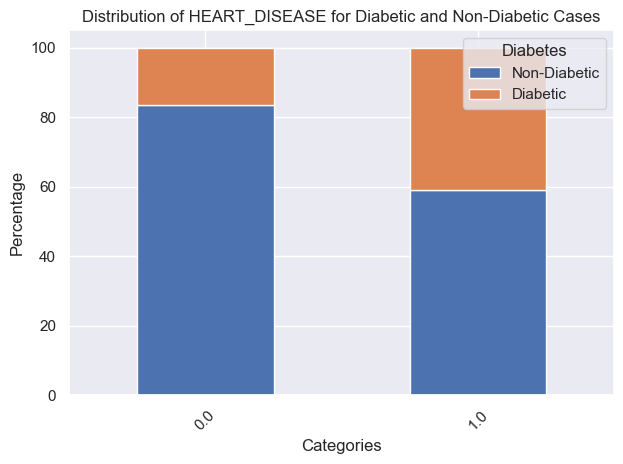

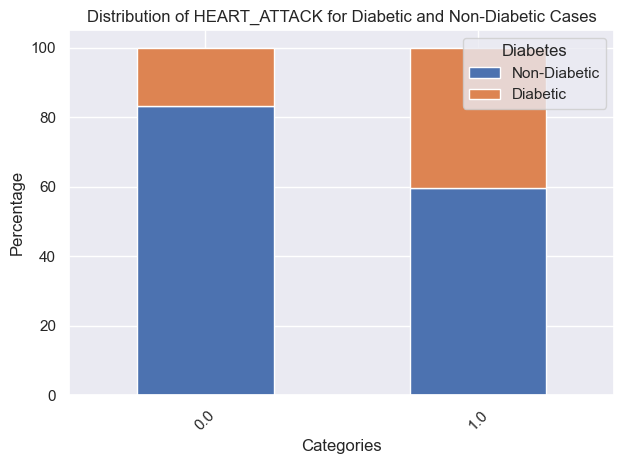

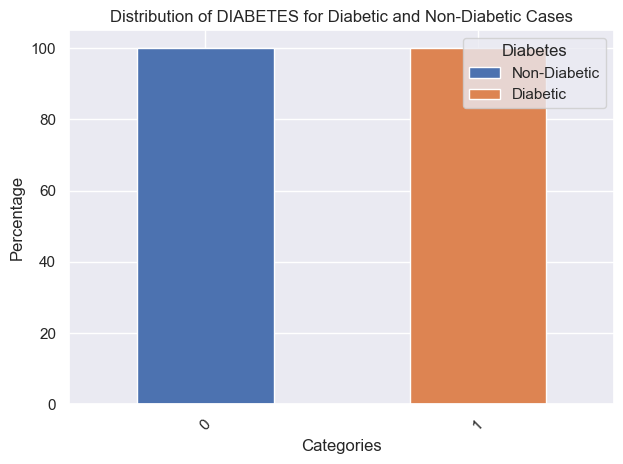

In [24]:
#Bar chart plotting process

for col in newdata.select_dtypes(include='category'):  # Select only categorical columns
    # Calculate frequency of each category for diabetic and non-diabetic cases
    category_frequency = newdata.groupby([col, 'DIABETES']).size().unstack()

    # Calculate percentage of diabetic and non-diabetic cases for each category
    category_frequency_percentage = category_frequency.div(category_frequency.sum(axis=1), axis=0) * 100

    # Plot bar chart for each category
    category_frequency_percentage.plot(kind='bar', stacked=True)
    plt.xlabel('Categories')
    plt.ylabel('Percentage')
    plt.title(f'Distribution of {col} for Diabetic and Non-Diabetic Cases')
    plt.legend(title='Diabetes', labels=['Non-Diabetic', 'Diabetic'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


The above shows a visualisation of correlation with DIABETES for each variable with a bar chart.

In [25]:
# Point-biserial correlation coefficient calculation process

# Define the list of variable pairs
variable_pairs = [('ALC_MONTH', 'DIABETES'),
                  ('POOR_HEALTH', 'DIABETES'),
                  ('AV_SLEEP', 'DIABETES')]

for pair in variable_pairs:
    # Calculate point-biserial correlation coefficient
    point_biserial_corr, p_value = pointbiserialr(newdata[pair[0]], newdata[pair[1]])

    print(f"Point-Biserial Correlation Coefficient ({pair[0]} vs {pair[1]}):", point_biserial_corr)
    
    # Interpretation of the strength of the relationship
    if abs(point_biserial_corr) >= 0.8:
        print("The relationship is very strong.")
    elif abs(point_biserial_corr) >= 0.5:
        print("The relationship is strong.")
    elif abs(point_biserial_corr) >= 0.2:
        print("The relationship is moderate.")
    else:
        print("The relationship is weak.")
    print()

Point-Biserial Correlation Coefficient (ALC_MONTH vs DIABETES): -0.14163909119424634
The relationship is weak.

Point-Biserial Correlation Coefficient (POOR_HEALTH vs DIABETES): 0.11227651057862167
The relationship is weak.

Point-Biserial Correlation Coefficient (AV_SLEEP vs DIABETES): 0.024138696837698044
The relationship is weak.



Point-Biserial Correlation is used to measure correlation of numerical variables with DIABETES.

In [26]:
# Rank-Biserial Correlation calculation process

# Define the list of variable pairs
variable_pairs = [('AGE_RANGE', 'DIABETES'),
                  ('BMI_CAT', 'DIABETES'),
                  ('HIGHEST_EDU', 'DIABETES'),
                  ('ANNUAL_INCOME', 'DIABETES'),
                  ('LAST_CHECKUP', 'DIABETES')]

for pair in variable_pairs:
    # Compute Rank-Biserial Correlation
    rank_biserial_corr, p_value = stats.pointbiserialr(newdata[pair[0]], newdata[pair[1]])
    
    # Print the Rank-Biserial Correlation coefficient
    print(f"Rank-Biserial Correlation Coefficient ({pair[0]} vs {pair[1]}):", rank_biserial_corr)

    # Interpretation of the strength of the relationship
    if abs(rank_biserial_corr) >= 0.8:
        print("The relationship is very strong.")
    elif abs(rank_biserial_corr) >= 0.5:
        print("The relationship is strong.")
    elif abs(rank_biserial_corr) >= 0.2:
        print("The relationship is moderate.")
    else:
        print("The relationship is weak.")
    print()

Rank-Biserial Correlation Coefficient (AGE_RANGE vs DIABETES): 0.2224550098171922
The relationship is moderate.

Rank-Biserial Correlation Coefficient (BMI_CAT vs DIABETES): 0.2057970328100075
The relationship is moderate.

Rank-Biserial Correlation Coefficient (HIGHEST_EDU vs DIABETES): -0.07549658847354038
The relationship is weak.

Rank-Biserial Correlation Coefficient (ANNUAL_INCOME vs DIABETES): -0.1174369427875461
The relationship is weak.

Rank-Biserial Correlation Coefficient (LAST_CHECKUP vs DIABETES): -0.15646114840768183
The relationship is weak.



Rank-Biserial Correlation is used to measure correlation of ordinal variables with DIABETES.

In [27]:
#Phi Coefficient calculation process

from scipy.stats import chi2_contingency

# Define the list of binary categorical variable pairs
binary_categorical_pairs = [('HEART_DISEASE', 'DIABETES'),
                            ('HEART_ATTACK', 'DIABETES'),
                            ('EXERCISE', 'DIABETES'),
                            ('COST_BARRIER', 'DIABETES'),
                            ('SMOKE_EVERYDAY', 'DIABETES'),
                            ('SMOKE_SOMEDAYS', 'DIABETES'),
                            ('DO_NOT_SMOKE', 'DIABETES'),
                            ('MALE', 'DIABETES'),
                            ('FEMALE', 'DIABETES'),
                            ('MARRIED', 'DIABETES'),
                            ('DIVORCED', 'DIABETES'),
                            ('WIDOWED', 'DIABETES'),
                            ('NEVER_MARRIED', 'DIABETES')]

for pair in binary_categorical_pairs:
    # Create a contingency table
    contingency_table = pd.crosstab(newdata[pair[0]], newdata[pair[1]])

    # Calculate Phi Coefficient
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    phi_coefficient = np.sqrt(chi2 / len(newdata))

    # Print the Phi Coefficient
    print(f"Phi Coefficient ({pair[0]} vs {pair[1]}):", phi_coefficient)

    # Interpretation of the strength of the association
    if phi_coefficient == 0:
        print("There is no association between the variables.")
    elif phi_coefficient < 0.1:
        print("The association between the variables is very weak.")
    elif phi_coefficient < 0.3:
        print("The association between the variables is moderate.")
    elif phi_coefficient < 0.6:
        print("The association between the variables is strong.")
    else:
        print("The association between the variables is very strong.")
    print()

Phi Coefficient (HEART_DISEASE vs DIABETES): 0.18897610639073018
The association between the variables is moderate.

Phi Coefficient (HEART_ATTACK vs DIABETES): 0.17819629266716283
The association between the variables is moderate.

Phi Coefficient (EXERCISE vs DIABETES): 0.15069856816114385
The association between the variables is moderate.

Phi Coefficient (COST_BARRIER vs DIABETES): 0.027071816116951905
The association between the variables is very weak.

Phi Coefficient (SMOKE_EVERYDAY vs DIABETES): 0.037815723668117175
The association between the variables is very weak.

Phi Coefficient (SMOKE_SOMEDAYS vs DIABETES): 0.04047718437945133
The association between the variables is very weak.

Phi Coefficient (DO_NOT_SMOKE vs DIABETES): 0.0598244846418739
The association between the variables is very weak.

Phi Coefficient (MALE vs DIABETES): 0.034045253860789215
The association between the variables is very weak.

Phi Coefficient (FEMALE vs DIABETES): 0.034045253860789215
The associati

Phi Coefficient is used to measure the correlation of dichotomous variables with DIABETES.

After EDA, we chose the variables with at least 'moderate' correlation with DIABETES, as well as an obvious visual relationship to be used for our next part. 

# Machine Learning Models 

### RANDOM FOREST

We chose to use a random forest model, a type of supervised learning algorithm, for our project. This model aggregates the outputs of multiple decision trees to make predictions, making it robust to outliers, suitable for non-linear data, and less prone to overfitting. It also performs efficiently on large datasets and often achieves higher accuracy compared to other classification algorithms.

In [28]:
newdata = newdata.astype(int)

In [29]:
predictors = ['AGE_RANGE', 'ANNUAL_INCOME', 'HIGHEST_EDU', 'BMI_CAT', 'HEART_DISEASE', 'HEART_ATTACK', 'EXERCISE']
X = newdata[predictors]
y = newdata['DIABETES']

# Split the data into training and test sets in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

In [30]:
# Random Forest with cross-validation for hyperparameter tuning of the Random Forest classifier

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=57)

# Define the hyperparameters grid to search
param_grid = {
    'max_depth': range(10,20)  # Example values for max_depth to tune
}

# Perform grid search with cross-validation (5-fold CV in this case)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best max_depth value
best_max_depth = grid_search.best_params_['max_depth']
print(f"Best max_depth value: {best_max_depth}")

# Train a final Random Forest model with the best max_depth value
final_rf = RandomForestClassifier(n_estimators=100, max_depth=best_max_depth, random_state=57)
final_rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = final_rf.predict(X_test)

# Evaluate the model's performance using metrics such as accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") 

# Calculate mean F1 score using cross-validation
f1_scorer = make_scorer(f1_score)
f1_scores = cross_val_score(final_rf, X_train, y_train, cv=5, scoring=f1_scorer)
mean_f1 = np.mean(f1_scores)
print(f"Mean F1 score: {mean_f1}")

# Calculate mean AUC score using cross-validation
auc_scorer = make_scorer(roc_auc_score)
auc_scores = cross_val_score(final_rf, X_train, y_train, cv=5, scoring=auc_scorer)
mean_auc = np.mean(auc_scores)
print(f"Mean AUC score: {mean_auc}")

Best max_depth value: 10
Accuracy: 0.811536444677504
Mean F1 score: 0.18138260442369342
Mean AUC score: 0.5431169870845438


As seen, we performed grid search to tune the Random Forest classifier's hyperparameters. Refining the max_depth range in hyperparameter tuning involves an iterative process. It begins with exploring a wide range of values, evaluating the model's performance for each value, and then narrowing down the range based on the results to focus on promising values. This approach enables systematic improvement of our model's performance by iteratively adjusting the hyperparameters based on performance evaluation.

To evaluate its performance, we conducted 5-fold cross-validation. This included dividing the dataset into five subsets, training the model on some subsets, testing on others, and averaging the results to get a reliable performance estimate. We used accuracy, F1 score, and AUC score as metrics.

*Accuracy*: Accuracy is a measure of the overall correctness of a model, calculated as the number of correct predictions divided by the total number of predictions. It provides a general indication of how often the model's predictions are correct.

*F1 Score*: The F1 score is a metric that combines both precision and recall into a single value. It is calculated as the harmonic mean of precision and recall, providing a balance between the two measures. It is particularly useful when the classes are imbalanced.

*AUC Score*: The AUC (Area Under the Curve) score is a metric that evaluates the performance of a binary classification model by measuring the area under the receiver operating characteristic (ROC) curve. It represents the model's ability to distinguish between positive and negative classes, with a higher score indicating better performance.

While its accuracy is high, its mean F1 and mean AUC score is low. This suggests that the Random Forest model is not performing well. A probable reason is that our dataset is imbalanced.

### RANDOM FOREST WITH SMOTE (Synthetic Minority Over-sampling Technique)

As such, we performed SMOTE to address this. SMOTE (Synthetic Minority Over-sampling Technique) is a technique used to address the class imbalance problem in machine learning. It works by generating synthetic samples for the minority class (the class with fewer instances) to balance the class distribution.

In [31]:
# Apply SMOTE to Random Forest model with cross-validation for hyperparameter tuning of the Random Forest classifier

# Apply SMOTE to the training data
smote = SMOTE(random_state=57)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [32]:
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=57)

# Define the hyperparameters grid to search
param_grid = {
    'max_depth': range(10,20) 
}

# Perform grid search with cross-validation (5-fold CV in this case)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)

# Get the best max_depth value
best_max_depth = grid_search.best_params_['max_depth']
print(f"Best max_depth value: {best_max_depth}")

# Train a final Random Forest model with the best max_depth value
final_rf = RandomForestClassifier(max_depth=best_max_depth, random_state=57)
final_rf.fit(X_resampled, y_resampled)

# Make predictions on the test data
y_pred = final_rf.predict(X_test)

# Evaluate the model's performance using metrics such as accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate mean F1 score using cross-validation
f1_scorer = make_scorer(f1_score)
f1_scores = cross_val_score(final_rf, X_resampled, y_resampled, cv=5, scoring=f1_scorer)
mean_f1 = np.mean(f1_scores)
print(f"Mean F1 score: {mean_f1}")

# Calculate mean AUC score using cross-validation
auc_scorer = make_scorer(roc_auc_score)
auc_scores = cross_val_score(final_rf, X_resampled, y_resampled, cv=5, scoring=auc_scorer)
mean_auc = np.mean(auc_scores)
print(f"Mean AUC score: {mean_auc}")

Best max_depth value: 15
Accuracy: 0.681489250131096
Mean F1 score: 0.7451876446890807
Mean AUC score: 0.7332847660676702


We can see that after applying SMOTE, mean F1 and mean AUC score increased significantly. Although accuracy decreased slightly, it still remains moderate. 

Overall, the above code effectively handles class imbalance with SMOTE and tunes the hyperparameters of the Random Forest classifier using GridSearch while evaluating its performance using cross-validation.

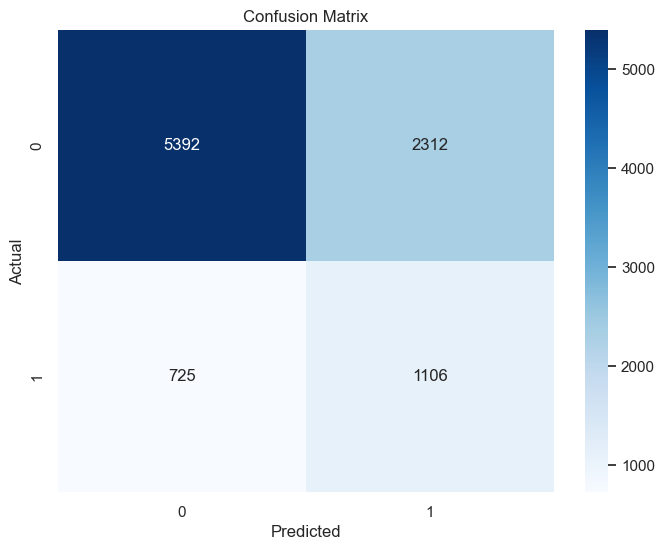

True Positive Rate (TPR): 0.60
False Positive Rate (FPR): 0.30
True Negative Rate (TNR): 0.70
False Negative Rate (FNR): 0.40


In [33]:
# Plot confusion matrix for random forest after SMOTE
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate true positives, false positives, true negatives, false negatives
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

# Calculate rates
TPR = TP / (TP + FN)  # True Positive Rate
FPR = FP / (FP + TN)  # False Positive Rate
TNR = TN / (TN + FP)  # True Negative Rate
FNR = FN / (FN + TP)  # False Negative Rate

print(f"True Positive Rate (TPR): {TPR:.2f}")
print(f"False Positive Rate (FPR): {FPR:.2f}")
print(f"True Negative Rate (TNR): {TNR:.2f}")
print(f"False Negative Rate (FNR): {FNR:.2f}")

A relatively high false negative rate after applying SMOTE could be due to our usage of SMOTE or Synthetic Minority Over-sampling Technique in order to help deal with the under-represented minority class that we believed led to a low F1 score calculated in our first instance of the random forest model without the usage of SMOTE. 
This is because while SMOTE is supposed to be used to balance the class distribution, it is not perfect and it may not have been able to properly over-sample the minority class. This may prevent the synthetic samples generated by SMOTE from capturing the full complexity and variability of the minority class, leading to misclassifications, thereby affecting false negative rate and the accuracy of the model. 

This same reason can be attributed to why our random forest model had a moderate accuracy score.

### SUPPORT VECTOR MACHINE (SVM)

In [34]:
#SVM
# Step 1: Split data into training and testing sets
# Step 2: Apply SMOTE to the training data

# Step 3: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 4: Model Training
svm_model = SVC(kernel='linear', random_state=57)  # Linear SVM
svm_model.fit(X_train_scaled, y_resampled)

# Step 5: Model Evaluation
y_pred = svm_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate and print F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate and print AUC score
auc = roc_auc_score(y_test, y_pred)
print("AUC Score:", auc)

              precision    recall  f1-score   support

           0       0.91      0.65      0.76      7704
           1       0.33      0.73      0.46      1831

    accuracy                           0.67      9535
   macro avg       0.62      0.69      0.61      9535
weighted avg       0.80      0.67      0.70      9535

Accuracy: 0.6677503932878868
F1 Score: 0.45623069001029865
AUC Score: 0.6898894401427362


The accuracy score is similar to that of random forest. However, the weighted average F1 score of this model is lower than the F1 score of the random forest model, suggesting that it is not performing as well in classification. 

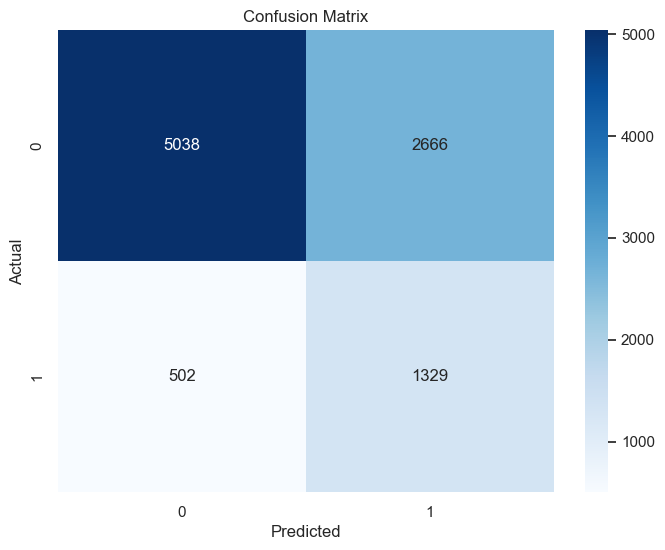

True Positive Rate (TPR): 0.73
False Positive Rate (FPR): 0.35
True Negative Rate (TNR): 0.65
False Negative Rate (FNR): 0.27


In [35]:
# SVM confusion matrix

# Step 5: Model Evaluation with Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Extract values from the confusion matrix
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]

# Calculate True Negative Rate (Specificity)
TNR = TN / (TN + FP)

# Calculate False Positive Rate
FPR = FP / (FP + TN)

# Extract values from the confusion matrix
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]

# Calculate True Positive Rate (Recall or Sensitivity)
TPR = TP / (TP + FN)

# Calculate False Negative Rate
FNR = FN / (FN + TP)

print(f"True Positive Rate (TPR): {TPR:.2f}")
print(f"False Positive Rate (FPR): {FPR:.2f}")
print(f"True Negative Rate (TNR): {TNR:.2f}")
print(f"False Negative Rate (FNR): {FNR:.2f}")

### LOGISTIC REGRESSION MODEL

In [36]:
# Create and fit the logistic regression model
model = LogisticRegression(class_weight='balanced')
model.fit(X_resampled, y_resampled)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

# Predict class labels
#predicted_labels = model.predict(X_test_scaled)

cv_scores = cross_val_score(model, X, y, cv=5)  # cv=5 for 5-fold cross-validation

cv_f1_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
cv_auc_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Calculate mean F1 score and AUC
mean_f1_score = cv_f1_scores.mean()
mean_auc = cv_auc_scores.mean()

# Print results
print("Mean F1 Score:", mean_f1_score)
print("Mean AUC Score:", mean_auc)

Accuracy: 0.6835867855270058
Mean F1 Score: 0.46433301267825133
Mean AUC Score: 0.7622488063064288


While accuracy of Logistic Regression Model may be higher than that of Random Forest, it has a significantly lower F1 score which suggests it has poorer performance in precision and recall. There may be a big difference between precision and recall, hence the F1 score.

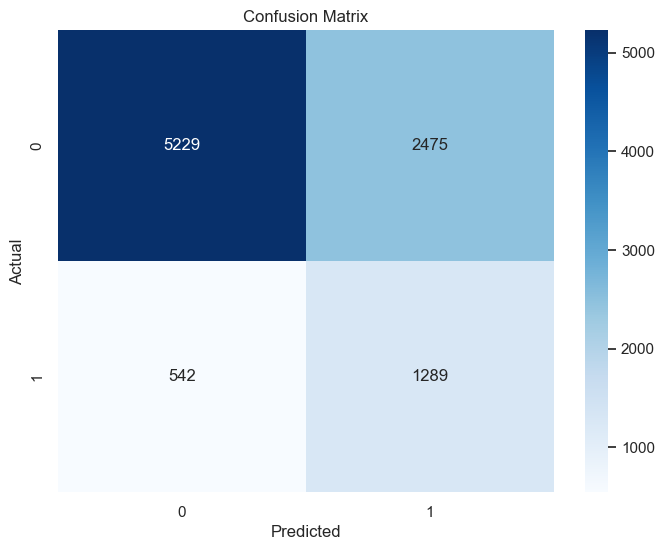

True Positive Rate (TPR): 0.70
False Positive Rate (FPR): 0.32
True Negative Rate (TNR): 0.68
False Negative Rate (FNR): 0.30


In [37]:
# Logistic regression model confusion matrix

predicted_labels = model.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate TP, TN, FP, FN from confusion matrix
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Calculate rates
FPR = FP / (FP + TN)
FNR = FN / (TP + FN)
TNR = TN / (TN + FP)
TPR = TP / (TP + FN)

# Print the rates
print(f"True Positive Rate (TPR): {TPR:.2f}")
print(f"False Positive Rate (FPR): {FPR:.2f}")
print(f"True Negative Rate (TNR): {TNR:.2f}")
print(f"False Negative Rate (FNR): {FNR:.2f}")